In [ ]:
# %pip install llama_index

In [ ]:
# %pip install -U llama-index
# %pip install -U llama-index-core
# # %pip install llama-index-embeddings-openai
# %pip install llama-index-postprocessor-flag-embedding-reranker
# %pip install git+https://github.com/FlagOpen/FlagEmbedding.git
# %pip install -U llama-parse
# %pip install -U llama-index-llms-llama-cpp
# %pip install -U llama-index-core-llms
# %pip install -U llama-index-embeddings-openai

In [1]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

import os

# API access to llama-cloud
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-SyHQUKzf4guxK5aU1QnzURVVl4sbQ4pqX5QzFh7SXhytaj8N"

# Using OpenAI API for embeddings/llms
os.environ["OPENAI_API_KEY"] = "sk-proj-Q0eWC0bJfIIaLkIGOaHOT3BlbkFJcAPgSc2VZCGKEPVJVtzI"

In [2]:
from llama_parse import LlamaParse

parser_gpt4o = LlamaParse(
    result_type="markdown",
    # api_key=api_key,
    gpt4o_mode=True,
    # gpt4o_api_key="<gpt4o_api_key>"
)

In [47]:
import os
import glob

# Define the folder containing the PDF files
data_folder = './data/'

# Use glob to find all PDF files in the folder
pdf_files = glob.glob(os.path.join(data_folder, '*.pdf'))
pdf_files

['./data\\Market Report_14 May 2024.pdf',
 './data\\Market Report_15 May 2024.pdf',
 './data\\Market Report_16 May 2024.pdf',
 './data\\Market Report_17 May 2024.pdf',
 './data\\Market Report_20 May 2024.pdf',
 './data\\Market Report_21 May 2024.pdf']

In [48]:
documents_gpt4o = parser_gpt4o.load_data(pdf_files)

Parsing files: 100%|██████████| 6/6 [00:56<00:00,  9.42s/it]


In [49]:
print(documents_gpt4o[0].get_content())

# SOLOMON Stockbrokers Limited
**Member of Dar es Salaam Stock Exchange**  
**Authorized Dealer of Government Securities**  
[www.solomon.co.tz](http://www.solomon.co.tz)  
**e-Market Report**

**Wednesday, May 15, 2024**

---

## Market Report for Tuesday, 14 May 2024

DSE recorded a total turnover of TZS 745.59 Mln from 279,686 shares traded in 153 deals and TZS 34.91 Bln from bonds traded in 13 deals.

On the Block Trade Pre-arranged Market board, NMB counter traded a block of 100,000 shares.

On the Normal Board, CRDB counter had 122,379 shares traded at a weighted average price of TZS 520 per share in 86 deals. DCB counter had 1,293 shares traded at a weighted average price of TZS 120 per share in 8 deals. MBP counter had 10 shares traded at a weighted average price of TZS 300 per share in 1 deal. NICO counter had 9,336 shares traded at a weighted average price of TZS 770 per share in 23 deals. NMB counter had 131,126 shares traded at a weighted average price of TZS 4,960 per shar

In [50]:
from copy import deepcopy
from llama_index.core.schema import TextNode
from llama_index.core import VectorStoreIndex


def get_nodes(docs):
    """Split docs into nodes, by separator."""
    nodes = []
    for doc in docs:
        doc_chunks = doc.text.split("\n---\n")
        for doc_chunk in doc_chunks:
            node = TextNode(
                text=doc_chunk,
                metadata=deepcopy(doc.metadata),
            )
            nodes.append(node)

    return nodes

In [51]:
# this will split into pages
nodes = get_nodes(documents_gpt4o)

In [52]:
vector_index = VectorStoreIndex(nodes)

In [53]:
query_engine = vector_index.as_query_engine(similarity_top_k=6)

In [54]:
response = query_engine.query(
    "Corporate Bonds Board, a 5-year bond?"
)

In [55]:
print(str(response))

Corporate Bonds Board does not have information on a 5-year bond in the provided context.


In [57]:
response = query_engine.query(
    "What is the price offer for CRDB for all days from 14 may to 21 May. Output in json {'date': date , 'price':price}?"
)
print(str(response))

{
    "date": "14 May 2024",
    "price": 520
},
{
    "date": "15 May 2024",
    "price": 500
},
{
    "date": "16 May 2024",
    "price": 500
},
{
    "date": "17 May 2024",
    "price": 490
},
{
    "date": "20 May 2024",
    "price": 480
},
{
    "date": "21 May 2024",
    "price": 480
}


In [58]:
import json
import re
import matplotlib.pyplot as plt
from datetime import datetime

In [62]:
# Use regular expressions to find all JSON objects in the string
json_objects = re.findall(r'\{[^}]+\}', str(response))

# Parse each JSON object and convert it to a dictionary
data_list = [json.loads(json_obj) for json_obj in json_objects]

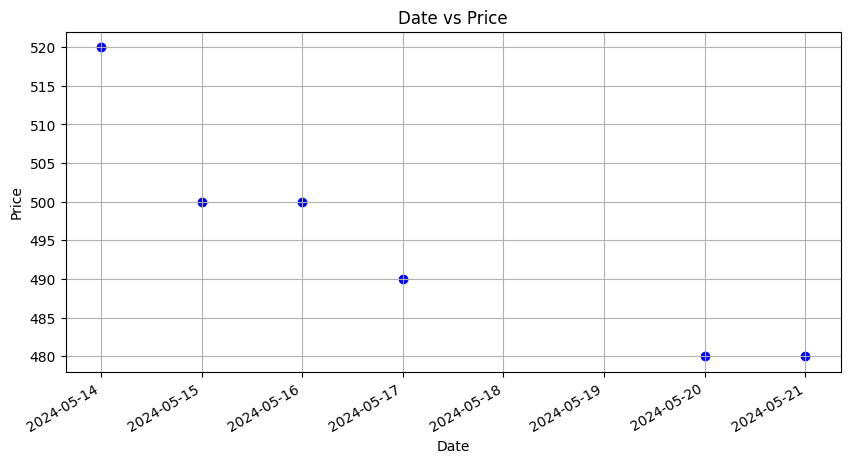

In [64]:
# Convert date strings to datetime objects and sort the data
sorted_data = sorted(data_list, key=lambda x: datetime.strptime(x['date'], '%d %b %Y'))

# Extract sorted dates and prices
dates = [datetime.strptime(item['date'], '%d %b %Y') for item in sorted_data]
prices = [item['price'] for item in sorted_data]

# Plot the data
plt.figure(figsize=(10, 5))
# plt.plot(dates, prices, marker='o', linestyle='-', color='b')
plt.scatter(dates, prices, marker='o', linestyle='-', color='b')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Date vs Price')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format date labels
plt.show()